**<h5></h5>**
**<h1><center>CS 464</center></h1>**
**<h1><center>Introduction to Machine Learning</center></h1>**
**<h1><center>Fall 2024</center></h1>**
**<h1><center>Homework 3</center></h1>**
<h4><center>Due: December 29, 2024 23:59 (GMT+3)</center></h4>

## **CIFAR-10 Inpainting**

### **Homework Description**

In this assignment, you are asked to design and train a convolutional neural network model for the image inpainting task. In short, inpainting is a process of filling in the missing parts of an image. You will be applying this task on the [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html?ref=assemblyai.com) images. It contains RGB real-life images with the size of 32x32 pixel resolution. You can see a subset of the dataset below. The download link of the dataset is provided in the following parts.

![CIFAR-100 Samples](https://drive.google.com/uc?export=view&id=1drp11GJ3QnRivkYLR0nh9RVOi9lnIh8o)

**Using PyTorch is mandatory** for this assignment. You are requested to **submit only a single *.ipynb file** in your submissions (no report needed). If you want to provide further explanations about your work, you can add Markdown cells for this purpose. From [this link](https://www.markdownguide.org/), you can get familiar with the Markdown syntax if you need. Upload your homework with the following filename convention: **\<BilkentID\>\_\<Name\>\_\<Surname\>.ipynb**

Note that this assignment needs a CUDA-enabled GPU to be able to train the models in a reasonable time. If you do not have one, it is suggested to use the [Colab](https://colab.research.google.com/) environment.

**Contact:** [İpek Öztaş](mailto:ipek.oztas@bilkent.edu.tr)

### **Importing the Libraries**

In the cell below,  some utilities that you can make use of in this assignment are imported. You can edit these imports considering your implementation as long as you use PyTorch.

In [1]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset
import torchvision
from torchvision import transforms
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random
import os

### **Environment Check**

In the cell below, you can test whether hardware acceleration with GPU is enabled in your machine or not. If it is enabled, the printed device should be 'cuda'.

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Current device:', device)

if device.type == 'cuda':
    print('GPU Name:', torch.cuda.get_device_name(0))
    print('Total GPU Memory:', round(torch.cuda.get_device_properties(0).total_memory/1024**3,1), 'GB')

Current device: cuda
GPU Name: NVIDIA GeForce RTX 3060 Laptop GPU
Total GPU Memory: 5.8 GB


### **Setting Library Seeds for Reproducibility**

**DO NOT CHANGE**<br>
To make a fair evaluation, the seed values are set for random sampling methods in PyTorch, NumPy, and Python random library. Please do not change these values.

In [3]:
def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

In [4]:
seed_everything(464)

### **Preparing the Dataset**

The CIFAR-10 dataset is downloadable from [this link](https://drive.google.com/file/d/1KSKSWiBKvfxBpWmDmuRvUkn77YvWaIFW/view?usp=sharing). If you are using Colab or a Linux machine, you can uncomment and run the below cell to download and extract the dataset automatically.

In [5]:
# !unzip /content/cifar10_dataset.zip
# !unzip cifar10_dataset.zip

Archive:  cifar10_dataset.zip
replace train/9/2679.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


### **Implementing a Custom Dataset [25 Points]**

In this part, you are requested to implement a custom PyTorch dataset class that reads CIFAR-10 images from a dataset split folder. There are two split folders called train and test in the dataset. The model class should take the root directory of a split in the \_\_init\_\_ function and read the images accordingly. Before returning the requested images, you should apply the following steps:

* Convert images to Tensor object
* Normalize tensor values to scale them in the range of (-1,1)

Note that reading images in the \_\_getitem\_\_ function makes the training process slow for this dataset because reading such small-sized images as a batch is slower than the forward pass process of a simple neural network. Therefore, it is suggested to read and store the images in an array in the \_\_init\_\_ function and return them in the \_\_getitem\_\_ function when they are requested by the DataLoader object.

In [6]:
class CifarDataset(Dataset):
    def __init__(self, root_dir):
        self.images = []
        self.labels = []
        for label in os.listdir(root_dir):
            for file in os.listdir(os.path.join(root_dir, label)):
                if file.endswith(".png"):
                    image = Image.open(os.path.join(root_dir, label, file))
                    image = transforms.ToTensor()(image)
                    image = (image * 2) - 1
                    self.images.append(image)
                    self.labels.append(torch.tensor(int(label)))
        
        self.images = torch.stack(self.images)
        self.labels = torch.stack(self.labels)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, data_id):
        return self.images[data_id]


Create a dataset and a data loader object for training and test splits. Set batch sizes to 64 and 512 for training and test data loaders, respectively. Enable shuffling in the training data loader and disable it in the test data loader.

In [7]:
train_dataset = CifarDataset("/home/akif/cs464/hw3/train")
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)

test_dataset = CifarDataset("/home/akif/cs464/hw3/test")
test_dataloader = DataLoader(test_dataset, batch_size=512, shuffle=False)

**Do not change** the below code. If your implementation is correct, you should be seeing a grid of CIFAR-10 images properly.

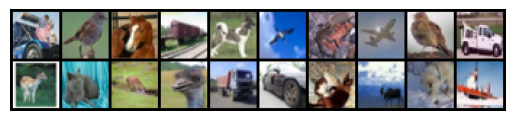

In [8]:
## Uncomment the cell when the dataloader is ready

images = next(iter(train_dataloader)) # Taking one batch from the dataloader
images = (images + 1) / 2
grid_img = torchvision.utils.make_grid(images[:20], nrow=10)
plt.axis('off')
plt.imshow(grid_img.permute(1, 2, 0))
plt.show()

### **Constructing Convolutional Autoencoder Network [35 Points]**

Autoencoder networks learn how to compress and reconstruct input data. It consists of two networks called the encoder and the decoder. The encoder network compresses the input data, and the decoder network regenerates the data from its compressed version. In this part, you are requested to implement an autoencoder model using convolutional layers. The architecture of the convolutional autoencoder is shown in the below figure.

![Convolutional Autoencoder Architecture](https://drive.google.com/uc?export=view&id=19RqHo2PatyoFl7om8OUxBRb1uYAVGmhF)

The (in_channel, out_channel) pairs of the layers should be defined as follows:

**Encoder:**
- (3, 16)
- (16, 32)
- (32, 64)

**Decoder:**
- (64, 32)
- (32, 16)
- (16, 3)

You are free to choose the kernel and padding sizes of the layers. In each layer, [2D batch normalization](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm2d.html) should be applied and the resulting values should be passed through a LeakyReLU layer with slope 0.2, which is the activation function. Since the image pixel value range is set to [-1,1] in the dataset, the outputs should be bounded so. Therefore, you should be using a Tanh activation function in the last layer instead of the normalization and LeakyReLU layers.

In the encoder part of the network, use max pooling in each layer for decreasing the resolution by half. The stride size should be set to one for the convolution layers. In the decoder network, use [transposed convolution](https://pytorch.org/docs/stable/generated/torch.nn.ConvTranspose2d.html) (deconvolution) layers with stride two for increasing the resolution back.

In [48]:
class CifarAutoencoder(nn.Module):
    def __init__(self):
        super(CifarAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(0.2),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.Tanh(),
            nn.MaxPool2d(2, 2),
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(32, 16, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(16, 3, kernel_size=4, stride=2, padding=1),
            nn.Tanh(),
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

### **Implementing the Training Loop [15 Points]**

Define your training loop in this function. In the following parts, this function will be called to train the convolutional autoencoder. The input arguments are provided below. Apply the training progress and return a list of losses that are calculated on each epoch. You should sum the iteration losses up during an epoch and take the mean of them to calculate the running loss of that epoch.

To be able to learn inpainting, you should mask the input images as follows:

![CIFAR Masking](https://drive.google.com/uc?export=view&id=1tlB0mNH4B5dKfokoe162qWgXgPDnOQi2)

Simply, you should set the input tensor columns starting from 16 to 32 as -1 (black pixel). For the loss function, you should use the original image as the ground truth image so that the network learns how to fill the masked area of the input image and output the restored image. Before assigning the black pixels, do not forget to clone the original image to use it later in the loss function.

In [57]:
def train_model(model, train_dataloader, optimizer, loss_func, num_epochs):
    losses = []
    for epoch in range(num_epochs):
        running_loss = 0.0
        for images in tqdm(train_dataloader, desc=f'Epoch {epoch+1}/{num_epochs}'):
            images = images.to(device)
            masked_images = images.clone()
            masked_images[:,:,:,16:] = -1
            optimizer.zero_grad()
            outputs = model(masked_images)
            loss = loss_func(outputs, images)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        epoch_loss = running_loss / len(train_dataloader)
        losses.append(epoch_loss)
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}')
    return losses

### **Implementing the Evaluation Function [15 Points]**

Implement an evaluation function that returns the mean MSE calculated over the test dataset samples.

In [58]:
def evaluate_model(model, test_dataloader):
    mse_loss = nn.MSELoss()
    total_loss = 0.0
    for images in tqdm(test_dataloader, desc='Evaluating'):
        images = images.to(device)
        masked_images = images.clone()
        masked_images[:,:,:,16:] = -1
        outputs = model(masked_images)
        loss = mse_loss(outputs, images)
        total_loss += loss.item()
    mean_loss = total_loss / len(test_dataloader)
    print(f'Evaluation Total Loss: {mean_loss:.4f}')
    return mean_loss

### **Inpainting Visualization Function**

The below code will be used to visualize the outputs of the trained models later. **Do not change the codes in the cell**.

In [59]:
def visualize_inpainting(model, dataset):
    seed_everything(464)
    dataloader = DataLoader(dataset, batch_size=10, shuffle=True)
    images = next(iter(dataloader)) # Taking one batch from the dataloader
    images = images
    model.eval()
    with torch.no_grad():
      masked_images = images.clone()
      masked_images[:,:,:,16:] = -1
      inpainted_images = model(masked_images.cuda()).cpu()
    images = (images + 1) / 2
    masked_images = (masked_images + 1) / 2
    inpainted_images = (inpainted_images + 1) / 2
    images_concat = torch.cat((images, masked_images, inpainted_images), dim=2)
    grid_img = torchvision.utils.make_grid(images_concat, nrow=10)
    plt.axis('off')
    plt.imshow(grid_img.permute(1, 2, 0))
    plt.show()

### **Training and Evaluating the Model [10 Points]**

Define your loss function as MSE, set learning rate to 2e-4, create Adam optimizer, and set number of epochs to 50. Later, call the train_model function that you implemented. Visualize the returned losses on a plot (loss vs. epoch). Lastly, call evaluate_model function that you implemented and print the mean square error that your model reached on the test dataset. Also, call the visualize_inpainting function to observe the final inpainting results on the test dataset.



Epoch 1/50: 100%|██████████| 782/782 [00:02<00:00, 348.07it/s]


Epoch [1/50], Loss: 0.1255


Epoch 2/50: 100%|██████████| 782/782 [00:02<00:00, 357.60it/s]


Epoch [2/50], Loss: 0.0961


Epoch 3/50: 100%|██████████| 782/782 [00:02<00:00, 359.32it/s]


Epoch [3/50], Loss: 0.0915


Epoch 4/50: 100%|██████████| 782/782 [00:02<00:00, 352.83it/s]


Epoch [4/50], Loss: 0.0893


Epoch 5/50: 100%|██████████| 782/782 [00:02<00:00, 367.78it/s]


Epoch [5/50], Loss: 0.0877


Epoch 6/50: 100%|██████████| 782/782 [00:02<00:00, 360.34it/s]


Epoch [6/50], Loss: 0.0865


Epoch 7/50: 100%|██████████| 782/782 [00:02<00:00, 358.45it/s]


Epoch [7/50], Loss: 0.0855


Epoch 8/50: 100%|██████████| 782/782 [00:02<00:00, 359.10it/s]


Epoch [8/50], Loss: 0.0850


Epoch 9/50: 100%|██████████| 782/782 [00:02<00:00, 355.31it/s]


Epoch [9/50], Loss: 0.0845


Epoch 10/50: 100%|██████████| 782/782 [00:02<00:00, 351.35it/s]


Epoch [10/50], Loss: 0.0839


Epoch 11/50: 100%|██████████| 782/782 [00:02<00:00, 356.25it/s]


Epoch [11/50], Loss: 0.0833


Epoch 12/50: 100%|██████████| 782/782 [00:02<00:00, 356.55it/s]


Epoch [12/50], Loss: 0.0830


Epoch 13/50: 100%|██████████| 782/782 [00:02<00:00, 356.79it/s]


Epoch [13/50], Loss: 0.0826


Epoch 14/50: 100%|██████████| 782/782 [00:02<00:00, 358.67it/s]


Epoch [14/50], Loss: 0.0824


Epoch 15/50: 100%|██████████| 782/782 [00:02<00:00, 361.59it/s]


Epoch [15/50], Loss: 0.0820


Epoch 16/50: 100%|██████████| 782/782 [00:02<00:00, 357.84it/s]


Epoch [16/50], Loss: 0.0818


Epoch 17/50: 100%|██████████| 782/782 [00:02<00:00, 356.91it/s]


Epoch [17/50], Loss: 0.0815


Epoch 18/50: 100%|██████████| 782/782 [00:02<00:00, 363.32it/s]


Epoch [18/50], Loss: 0.0814


Epoch 19/50: 100%|██████████| 782/782 [00:02<00:00, 354.58it/s]


Epoch [19/50], Loss: 0.0811


Epoch 20/50: 100%|██████████| 782/782 [00:02<00:00, 364.04it/s]


Epoch [20/50], Loss: 0.0809


Epoch 21/50: 100%|██████████| 782/782 [00:02<00:00, 354.19it/s]


Epoch [21/50], Loss: 0.0807


Epoch 22/50: 100%|██████████| 782/782 [00:02<00:00, 351.93it/s]


Epoch [22/50], Loss: 0.0806


Epoch 23/50: 100%|██████████| 782/782 [00:02<00:00, 359.43it/s]


Epoch [23/50], Loss: 0.0805


Epoch 24/50: 100%|██████████| 782/782 [00:02<00:00, 353.60it/s]


Epoch [24/50], Loss: 0.0803


Epoch 25/50: 100%|██████████| 782/782 [00:02<00:00, 354.30it/s]


Epoch [25/50], Loss: 0.0800


Epoch 26/50: 100%|██████████| 782/782 [00:02<00:00, 354.35it/s]


Epoch [26/50], Loss: 0.0800


Epoch 27/50: 100%|██████████| 782/782 [00:02<00:00, 353.19it/s]


Epoch [27/50], Loss: 0.0798


Epoch 28/50: 100%|██████████| 782/782 [00:02<00:00, 359.31it/s]


Epoch [28/50], Loss: 0.0798


Epoch 29/50: 100%|██████████| 782/782 [00:02<00:00, 353.70it/s]


Epoch [29/50], Loss: 0.0797


Epoch 30/50: 100%|██████████| 782/782 [00:02<00:00, 346.26it/s]


Epoch [30/50], Loss: 0.0795


Epoch 31/50: 100%|██████████| 782/782 [00:02<00:00, 348.25it/s]


Epoch [31/50], Loss: 0.0795


Epoch 32/50: 100%|██████████| 782/782 [00:02<00:00, 354.93it/s]


Epoch [32/50], Loss: 0.0793


Epoch 33/50: 100%|██████████| 782/782 [00:02<00:00, 350.98it/s]


Epoch [33/50], Loss: 0.0792


Epoch 34/50: 100%|██████████| 782/782 [00:02<00:00, 357.85it/s]


Epoch [34/50], Loss: 0.0791


Epoch 35/50: 100%|██████████| 782/782 [00:02<00:00, 352.07it/s]


Epoch [35/50], Loss: 0.0790


Epoch 36/50: 100%|██████████| 782/782 [00:02<00:00, 364.61it/s]


Epoch [36/50], Loss: 0.0789


Epoch 37/50: 100%|██████████| 782/782 [00:02<00:00, 357.73it/s]


Epoch [37/50], Loss: 0.0788


Epoch 38/50: 100%|██████████| 782/782 [00:02<00:00, 367.26it/s]


Epoch [38/50], Loss: 0.0786


Epoch 39/50: 100%|██████████| 782/782 [00:02<00:00, 361.92it/s]


Epoch [39/50], Loss: 0.0786


Epoch 40/50: 100%|██████████| 782/782 [00:02<00:00, 361.59it/s]


Epoch [40/50], Loss: 0.0785


Epoch 41/50: 100%|██████████| 782/782 [00:02<00:00, 362.03it/s]


Epoch [41/50], Loss: 0.0785


Epoch 42/50: 100%|██████████| 782/782 [00:02<00:00, 359.42it/s]


Epoch [42/50], Loss: 0.0784


Epoch 43/50: 100%|██████████| 782/782 [00:02<00:00, 368.12it/s]


Epoch [43/50], Loss: 0.0784


Epoch 44/50: 100%|██████████| 782/782 [00:02<00:00, 367.54it/s]


Epoch [44/50], Loss: 0.0782


Epoch 45/50: 100%|██████████| 782/782 [00:02<00:00, 365.35it/s]


Epoch [45/50], Loss: 0.0781


Epoch 46/50: 100%|██████████| 782/782 [00:02<00:00, 362.31it/s]


Epoch [46/50], Loss: 0.0780


Epoch 47/50: 100%|██████████| 782/782 [00:02<00:00, 365.03it/s]


Epoch [47/50], Loss: 0.0780


Epoch 48/50: 100%|██████████| 782/782 [00:02<00:00, 363.00it/s]


Epoch [48/50], Loss: 0.0779


Epoch 49/50: 100%|██████████| 782/782 [00:02<00:00, 359.96it/s]


Epoch [49/50], Loss: 0.0779


Epoch 50/50: 100%|██████████| 782/782 [00:02<00:00, 368.55it/s]


Epoch [50/50], Loss: 0.0777


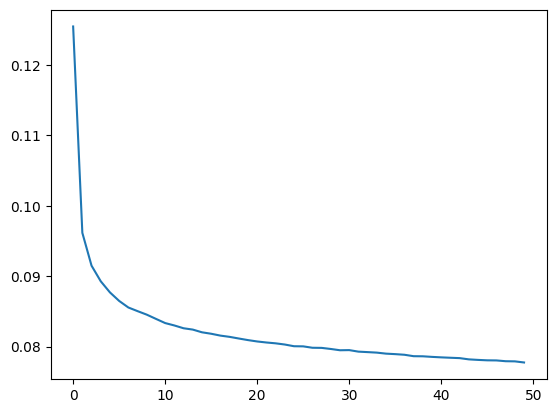

Evaluating: 100%|██████████| 20/20 [00:00<00:00, 130.61it/s]

Evaluation Total Loss: 0.0836


0.0836245521903038

In [60]:
seed_everything(464)
model = CifarAutoencoder()
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=2e-4)
loss_func = nn.MSELoss()
num_epochs = 50

losses = train_model(model, train_dataloader, optimizer, loss_func, num_epochs)
plt.plot(losses)
plt.show()

evaluate_model(model, test_dataloader)

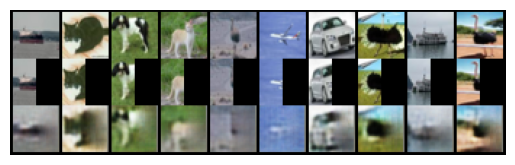

In [61]:
visualize_inpainting(model, test_dataset) ## Uncomment when the model is trained